In [1]:
# # Uncomment the this cell when running on Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

# import os
# # Make sure to change the following line to reflect the location of your root folder

# os.chdir('/content/gdrive/My Drive/2/Mask_RCNN_TF2')

In [2]:
import sys
sys.path.append("mrcnn")  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

2021-07-29 15:45:41.483558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-29 15:45:41.483587: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import os
import json
import datetime
import numpy as np
print("Numpy version: ",np.__version__) # 1.19.2
import skimage.draw
import tensorflow as tf
print("TensorFlow version: ",tf.__version__) #2.5.0
import random
import matplotlib.pyplot as plt

Numpy version:  1.19.2
TensorFlow version:  2.5.0


In [5]:
# Locations
ROOT_DIR = './'
DATA_DIR = './datasets/fruits2'
DEFAULT_LOGS_DIR = './assets/logs'

In [6]:
# Local path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
else:
    print("COCO weights already exists")


COCO weights already exists


In [7]:
class FruitsConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "fruit"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU =   1

    # Number of classes (including background)
    NUM_CLASSES = 2  # Background + fruit

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.10

In [8]:
############################################################
#  Dataset
############################################################

class FruitsDataset(utils.Dataset):

    def load_fruit(self, dataset_dir, subset):
        """
        Load a subset of the Fruits dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("fruit", 1, "fruit")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        
        # We are majorly interested with x and y values

        # Load the JSON annotations file
        annotations = json.load(open(os.path.join(dataset_dir, "via_project_fruits.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny - Around ~3K images

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            self.add_image(
                "fruit",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a fruit dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "fruit":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.float32) #dtype=np.int32

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fruit":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)       

# TESTING THE MODEL ON SAMPLE DATA

In [9]:
# Local path to trained weights file

TRAINED_MODEL_PATH = "assets/logs/fruits220210518T1629/mask_rcnn_fruits2_0192.h5"
# Download COCO trained weights from Releases if needed if there's no trained model
if not os.path.exists(TRAINED_MODEL_PATH):
    print('Info: Trained model does not exist on the path given.')
    if not os.path.exists(COCO_WEIGHTS_PATH):
        print('Info: Since model does not exist on the given but COCO weight are downloaded')
        utils.download_trained_weights(COCO_WEIGHTS_PATH)
    else:
        print('Info: Using COCO weights instead.')
        TRAINED_MODEL_PATH = COCO_WEIGHTS_PATH
else:
    print('Info: Nice! Model exists on the given path! ')

Info: Nice! Model exists on the given path! 


In [11]:
config = FruitsConfig()
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir="./trained", config=config)

# Load weights trained on MS-COCO
model.load_weights(TRAINED_MODEL_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


2021-07-29 15:46:20.870297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-29 15:46:20.870330: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-29 15:46:20.870349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kiprono-pc): /proc/driver/nvidia/version does not exist
2021-07-29 15:46:22.972707: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-29 15:46:23.732029: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2112000000

Re-starting from epoch 192


In [12]:
# Class names
class_names = ['BG', 'fruit']

_MG_8065_20.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/kiprono/Documents/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-07-29 15:46:36.734375: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.
2021-07-29 15:46:36.920433: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.
2021-07-29 15:46:37.075215: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.
2021-07-29 15:46:37.123656: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.
2021-07-29 15:46:37.294620: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation

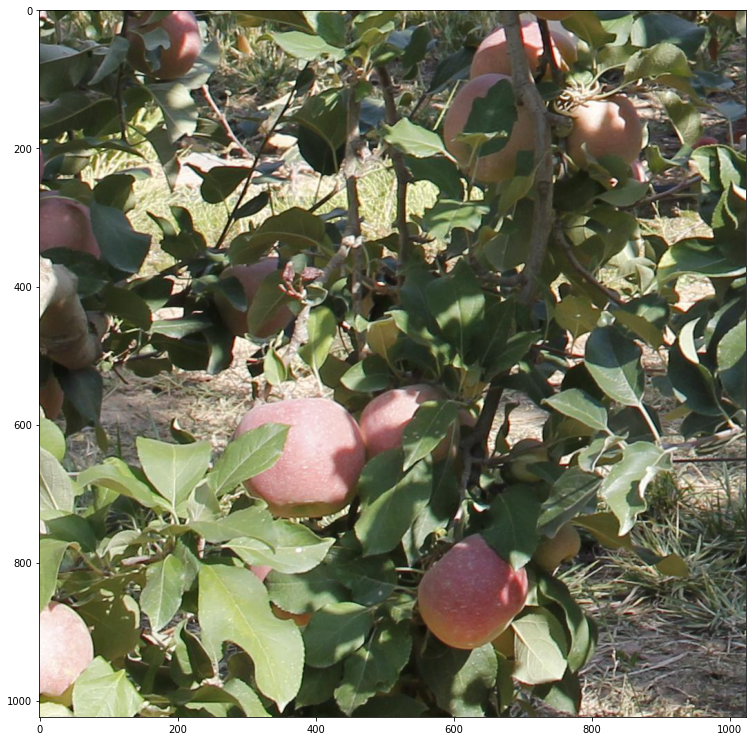

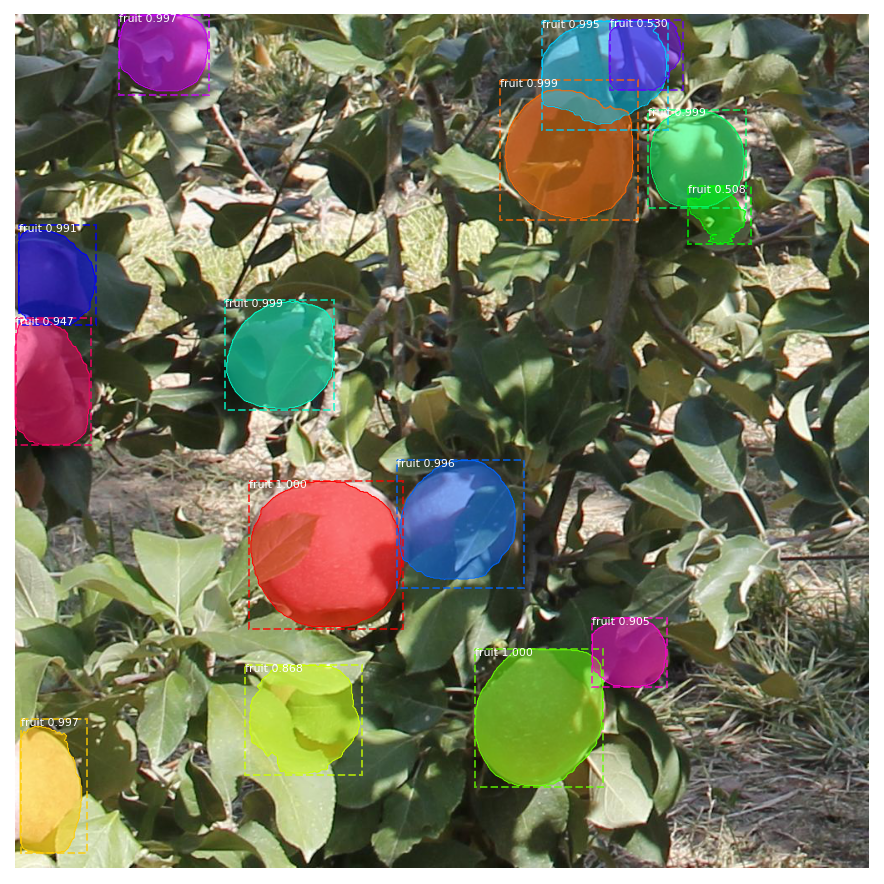

In [13]:
# Load a random image from the images folder
file_names = [item for item in os.listdir(os.path.join(DATA_DIR,"test")) \
             if  not item.startswith("via") and item.startswith("_MG_")]
file_ = random.choice(file_names)
print(file_)
# read image using scikit image library
image = skimage.io.imread(os.path.join(DATA_DIR,"test",file_))
# mrcnn_checkpoint = model.run_graph([image], [
# ("detections", model.keras_model.get_layer("mrcnn_detection").output)])
# # display RGB image
# image = skimage.io.imread("_MG_3168.JPG")
plt.figure(figsize=(15,13))
plt.imshow(image)
# Run detection'
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
display_ = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# RUNNING DETECTION ON ALL THE IMAGES IN ALL THE SETS - TRAIN, VAL AND TEST

In [ ]:
set1 = TRAINED_MODEL_PATH.split('/')[-2]+'-'\
+TRAINED_MODEL_PATH.split('/')[-1].replace('mask_rcnn_fruits2_','').replace('.h5','')
sets = ["train","val","test"] # train, val or test

for set2 in sets:
    #capture images that have been processed already so that we don't redo
    if not os.path.exists("./output/{}/{}_masks2".format(set1,set2)):
        os.makedirs("./output/{}/{}_masks2".format(set1,set2))
    done = os.listdir("./output/{}/{}_masks2".format(set1,set2))
    done
    ## loop through all train images and save masks

    #print([i for i in done if i.startswith("_")])
    files = [i for i in os.listdir(DATA_DIR+"/{}".format(set2)) if not i.startswith("via")];
    for index,file_ in enumerate(files):
        file1, _ = os.path.splitext(file_)
        f = "{}_mask2.npy".format(file1)
        if f in done:
            print(index,f,"is done.Passing.")
            continue
        else:
            
            print(index,file_)
            image = skimage.io.imread(os.path.join(DATA_DIR+"/{}".format(set2), file_))
            # Run detection
            results = model.detect([image], verbose=1)
            # Visualize results
            r = results[0]
            print(r["masks"].shape)
            file_,_ = os.path.splitext(file_)
            filename = "./output/{}/{}_masks2/{}_mask2.npy".format(set1,set2,file_)
            masks = []
            for i in range(len(r["scores"])):
                a = {
                    "filename" : None,
                    "mask" : None,
                    "confidence" : None,
                    "box" : None
                }
                a["filename"] = file_
                a["mask"] = r["mask_scores"][:,:,i]
                a["confidence"] = r["scores"][i]
                a["box"] = r["rois"][i]
                masks.append(a)

            masks = np.array(masks)
            np.save(filename,masks)
            print(filename)
            